# DESeq2
# Phase 1 vs. Phase 1

focusing on pairwise comparisons involving oysters that experienced only **one** phase 1 (one exposure)

## 0. load libraries

In [43]:
library(tidyverse)
library(DESeq2)
library(EnhancedVolcano)

Loading required package: ggrepel



## 1. read counts matrix and meta data

### counts matrix

In [3]:
# counts matrix
counts <- read.csv('/work/pi_sarah_gignouxwolfsohn_uml_edu/julia_mcdonough_student_uml_edu/ce24_rnaseq/featureCounts/featureCounts_matrix.csv')

# set gene_ID as row name
rownames(counts) <- counts$Gene_ID

# remove gene id and length
counts <- counts %>%
select(-Gene_ID, -Length)

head(counts)

,B1_B1_O01,B1_Nu_O03,B1_W5_O50,B2_B5_O51,B2_C4_O40,B2_Nu_O12,B3_B4_O41,B3_C3_O30,B3_C6_O66,B3_H4_O41,⋯,W5_C4_G45,W5_H4_G46,W5_W2_G22,W6_B3_G35,W6_B4_G48,W6_H6_G71,W6_Nu_G41,W6_Nu_G45,W6_W3_G36,W6_W4_G48
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
LOC111116054,2,1,6,10,9,16,0,10,22,9,⋯,9,2,8,5,2,19,1,2,1,0
LOC111126949,885,652,477,654,586,523,392,357,496,540,⋯,407,740,707,406,418,424,492,330,281,599
LOC111110729,64,209,93,63,100,177,76,98,235,181,⋯,70,149,121,115,126,108,118,115,127,213
LOC111112434,11,7,2,0,2,2,12,15,10,36,⋯,11,6,4,0,2,16,22,0,8,0
LOC111120752,360,586,336,426,351,417,236,278,761,373,⋯,359,345,438,278,287,416,621,251,333,430
LOC111128944,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,1,0,0


### meta data

In [4]:
# create df with col names from counts matrix
meta <- as.data.frame(colnames(counts))

colnames(meta) <- 'Sample'

# Separate into columns
meta <- meta %>%
   # Keep original SampleID
  mutate(OGSample = Sample) %>%
  # Split by '_'
  separate(Sample, into = c("Phase1", "Phase2", "Tag"), sep = "_") %>%
  mutate(
    Phase1_Treatment = substr(Phase1, 1, 1),
    Phase1_TankRep    = as.numeric(substr(Phase1, 2, nchar(Phase1))),
    Phase2_Treatment = gsub("[0-9]", "", Phase2),
    Phase2_TankRep       = as.numeric(gsub("[A-Za-z]", "", Phase2))
  ) %>%
  select(OGSample, Phase1_Treatment, Phase1_TankRep, Phase2_Treatment, Phase2_TankRep, Tag)

colnames(meta)[1] <- 'Sample'

head(meta)

,Sample,Phase1_Treatment,Phase1_TankRep,Phase2_Treatment,Phase2_TankRep,Tag
,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>
1,B1_B1_O01,B,1,B,1,O01
2,B1_Nu_O03,B,1,Nu,NA,O03
3,B1_W5_O50,B,1,W,5,O50
4,B2_B5_O51,B,2,B,5,O51
5,B2_C4_O40,B,2,C,4,O40
6,B2_Nu_O12,B,2,Nu,NA,O12


In [5]:
# adding treatment info
meta2 <- meta %>%
mutate(
    ## phase 1 treatments
    # overall
    Phase1_treatment = case_when(
        Phase1_Treatment == 'B' ~ 'both',
        Phase1_Treatment == 'H' ~ 'hypoxic',
        Phase1_Treatment == 'W' ~ 'warm',
        Phase1_Treatment == 'C' ~ 'control',
    TRUE ~ NA_character_),
    
    # temp
    Phase1_temp = case_when(
        Phase1_Treatment == 'B' ~ 'warm',
        Phase1_Treatment == 'H' ~ 'ambient',
        Phase1_Treatment == 'W' ~ 'warm',
        Phase1_Treatment == 'C' ~ 'ambient',
    TRUE ~ NA_character_),

    # dissolved oxygen
    Phase1_DO = case_when(
        Phase1_Treatment == 'B' ~ 'hypoxic',
        Phase1_Treatment == 'H' ~ 'hypoxic',
        Phase1_Treatment == 'W' ~ 'normoxic',
        Phase1_Treatment == 'C' ~ 'normoxic',
    TRUE ~ NA_character_),
    
    ## phase 2 treatments
    # overall
    Phase2_treatment = case_when(
        Phase2_Treatment == 'B' ~ 'both',
        Phase2_Treatment == 'H' ~ 'hypoxic',
        Phase2_Treatment == 'W' ~ 'warm',
        Phase2_Treatment == 'C' ~ 'control',
    TRUE ~ NA_character_),
    
    # temp
    Phase2_temp = case_when(
        Phase2_Treatment == 'B' ~ 'warm',
        Phase2_Treatment == 'H' ~ 'ambient',
        Phase2_Treatment == 'W' ~ 'warm',
        Phase2_Treatment == 'C' ~ 'ambient',
    TRUE ~ NA_character_),

    # dissolved oxygen
    Phase2_DO = case_when(
        Phase2_Treatment == 'B' ~ 'hypoxic',
        Phase2_Treatment == 'H' ~ 'hypoxic',
        Phase2_Treatment == 'W' ~ 'normoxic',
        Phase2_Treatment == 'C' ~ 'normoxic',
    TRUE ~ NA_character_)) %>%
select(Sample, Phase1_treatment, Phase1_temp, Phase1_DO, Phase1_TankRep, Phase2_treatment, Phase2_temp, Phase2_DO, Phase2_TankRep)

head(meta2)

,Sample,Phase1_treatment,Phase1_temp,Phase1_DO,Phase1_TankRep,Phase2_treatment,Phase2_temp,Phase2_DO,Phase2_TankRep
,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>
1,B1_B1_O01,both,warm,hypoxic,1,both,warm,hypoxic,1
2,B1_Nu_O03,both,warm,hypoxic,1,NA,NA,NA,NA
3,B1_W5_O50,both,warm,hypoxic,1,warm,warm,normoxic,5
4,B2_B5_O51,both,warm,hypoxic,2,both,warm,hypoxic,5
5,B2_C4_O40,both,warm,hypoxic,2,control,ambient,normoxic,4
6,B2_Nu_O12,both,warm,hypoxic,2,NA,NA,NA,NA


In [41]:
write.csv(meta2, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/sample_metaData.csv')

for this analysis, only looking at Phase 1 samples, so pulling those out

In [6]:
# if skipped above code:
meta2 <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/sample_metaData.csv')

In [7]:
# selecting only phase 1 sample
p1_meta <- meta2 %>%
filter(grepl("Nu", Sample)) %>%
filter(Sample != 'B3_Nu_O24') # this sample failed all QC steps, removing from analysis

# setting samples as rownames and deleting col from df
rownames(p1_meta) <- p1_meta$Sample
p1_meta <- p1_meta[, !colnames(p1_meta) %in% "Sample"]

p1_meta

,X,Phase1_treatment,Phase1_temp,Phase1_DO,Phase1_TankRep,Phase2_treatment,Phase2_temp,Phase2_DO,Phase2_TankRep
,<int>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<int>
B1_Nu_O03,2,both,warm,hypoxic,1,NA,NA,NA,NA
B2_Nu_O12,6,both,warm,hypoxic,2,NA,NA,NA,NA
B4_Nu_O32,19,both,warm,hypoxic,4,NA,NA,NA,NA
B5_Nu_O36,25,both,warm,hypoxic,5,NA,NA,NA,NA
B6_Nu_O47,30,both,warm,hypoxic,6,NA,NA,NA,NA
C1_Nu_W01,35,control,ambient,normoxic,1,NA,NA,NA,NA
C1_Nu_W05,36,control,ambient,normoxic,1,NA,NA,NA,NA
C2_Nu_W15,40,control,ambient,normoxic,2,NA,NA,NA,NA
C3_Nu_W21,44,control,ambient,normoxic,3,NA,NA,NA,NA


In [8]:
# pulling out only phase 1 counts
p1_counts <- counts[,colnames(counts) %in% rownames(p1_meta)]
head(p1_counts)

,B1_Nu_O03,B2_Nu_O12,B4_Nu_O32,B5_Nu_O36,B6_Nu_O47,C1_Nu_W01,C1_Nu_W05,C2_Nu_W15,C3_Nu_W21,C4_Nu_W29,⋯,H3_Nu_B18,H4_Nu_B28,H5_Nu_B35,H6_Nu_B45,W1_Nu_G02,W2_Nu_G15,W3_Nu_G21,W4_Nu_G27,W6_Nu_G41,W6_Nu_G45
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
LOC111116054,1,16,13,11,1,16,2,1,2,10,⋯,16,29,15,0,3,23,12,9,1,2
LOC111126949,652,523,444,1438,609,525,1076,541,566,613,⋯,451,608,745,394,1362,1235,270,407,492,330
LOC111110729,209,177,207,154,184,148,144,161,155,259,⋯,136,151,221,143,231,64,91,140,118,115
LOC111112434,7,2,10,19,18,11,17,21,18,18,⋯,6,6,25,5,24,0,10,7,22,0
LOC111120752,586,417,388,202,330,848,236,156,699,712,⋯,278,406,282,230,430,458,929,433,621,251
LOC111128944,0,0,0,0,0,0,2,4,0,6,⋯,14,2,0,0,2,0,4,0,0,1


In [9]:
# setting the same order for counts matrix and meta data
p1_counts <- p1_counts[,rownames(p1_meta)]
all(rownames(p1_meta) == colnames(p1_counts))

[1] TRUE

## 2. DESeq2
analyzing differential gene expression with [`DESeq2`](https://bioconductor.org/packages/release/bioc/vignettes/DESeq2/inst/doc/DESeq2.html)

#### contrasts
setting up contrasts (telling DESeq what is the control treatment)

In [10]:
# overall phase 1 treatment
p1_meta$Phase1_treatment <- factor(p1_meta$Phase1_treatment,
                                   levels = c('control', 'both', 'hypoxic', 'warm'))

In [11]:
# phase 1 tempature
p1_meta$Phase1_temp <- factor(p1_meta$Phase1_temp,
                                   levels = c('ambient', 'warm'))

In [12]:
# phase 1 DO
p1_meta$Phase1_DO <- factor(p1_meta$Phase1_DO,
                                   levels = c('normoxic', 'hypoxic'))

### phase 1 overall treatments
starting simple with looking at phase 1 treatments (not splitting into temperature/DO, just looking at combination of treatments)

In [53]:
# creating DESeq2 object
dds <- DESeqDataSetFromMatrix(countData = p1_counts,
                              colData = p1_meta,
                              design = ~ Phase1_treatment)
dds

# running DESeq
dds <- DESeq(dds)

# list coefficients
resultsNames(dds)

class: DESeqDataSet 
dim: 38838 23 
metadata(1): version
assays(1): counts
rownames(38838): LOC111116054 LOC111126949 ... ND1 ND4L
rowData names(0):
colnames(23): B1_Nu_O03 B2_Nu_O12 ... W6_Nu_G41 W6_Nu_G45
colData names(9): X Phase1_treatment ... Phase2_DO Phase2_TankRep

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



[1] "Intercept"                           "Phase1_treatment_both_vs_control"   
[3] "Phase1_treatment_hypoxic_vs_control" "Phase1_treatment_warm_vs_control"

### phase 1 warm vs. control

In [54]:
res.wc <- results(dds, name = 'Phase1_treatment_warm_vs_control', alpha=0.05)
res.wc

log2 fold change (MLE): Phase1 treatment warm vs control 
Wald test p-value: Phase1 treatment warm vs control 
DataFrame with 38838 rows and 6 columns
              baseMean log2FoldChange     lfcSE       stat    pvalue      padj
             <numeric>      <numeric> <numeric>  <numeric> <numeric> <numeric>
LOC111116054   8.73976      0.6941807  0.929504  0.7468294 0.4551665  0.978861
LOC111126949 670.50908     -0.0320688  0.430989 -0.0744075 0.9406862  0.999277
LOC111110729 160.01831     -0.4470838  0.205679 -2.1737021 0.0297275  0.556741
LOC111112434  13.04807     -0.8336678  0.753768 -1.1060011 0.2687261  0.920444
LOC111120752 403.23352      0.3428400  0.356561  0.9615186 0.3362915  0.948800
...                ...            ...       ...        ...       ...       ...
ND5           214540.0      0.2645784  0.221311   1.195508  0.231889  0.904759
ND6            76772.9     -0.3168426  0.247721  -1.279028  0.200887  0.887084
ND3            32972.9     -0.0776149  0.226158  -0.343189 

#### lfc shrinkage for visualization and ranking

In [55]:
res.wcLFC <- lfcShrink(dds, coef = 'Phase1_treatment_warm_vs_control', type = 'apeglm')
res.wcLFC

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



log2 fold change (MAP): Phase1 treatment warm vs control 
Wald test p-value: Phase1 treatment warm vs control 
DataFrame with 38838 rows and 5 columns
              baseMean log2FoldChange     lfcSE    pvalue      padj
             <numeric>      <numeric> <numeric> <numeric> <numeric>
LOC111116054   8.73976    0.002749007 0.0591615 0.4551665  0.962815
LOC111126949 670.50908   -0.000549764 0.0586348 0.9406862  0.998374
LOC111110729 160.01831   -0.041662805 0.0787389 0.0297275  0.535282
LOC111112434  13.04807   -0.005042656 0.0593295 0.2687261  0.894693
LOC111120752 403.23352    0.009327586 0.0594573 0.3362915  0.926629
...                ...            ...       ...       ...       ...
ND5           214540.0     0.01848264 0.0611748  0.231889  0.877236
ND6            76772.9    -0.01771087 0.0613147  0.200887  0.858967
ND3            32972.9    -0.00493761 0.0575343  0.731456  0.991361
ND1           180539.7     0.01409470 0.0595106  0.350870  0.931420
ND4L           10161.8     0.0091


out of 34981 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 72, 0.21%
LFC < 0 (down)     : 86, 0.25%
outliers [1]       : 839, 2.4%
low counts [2]     : 2649, 7.6%
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



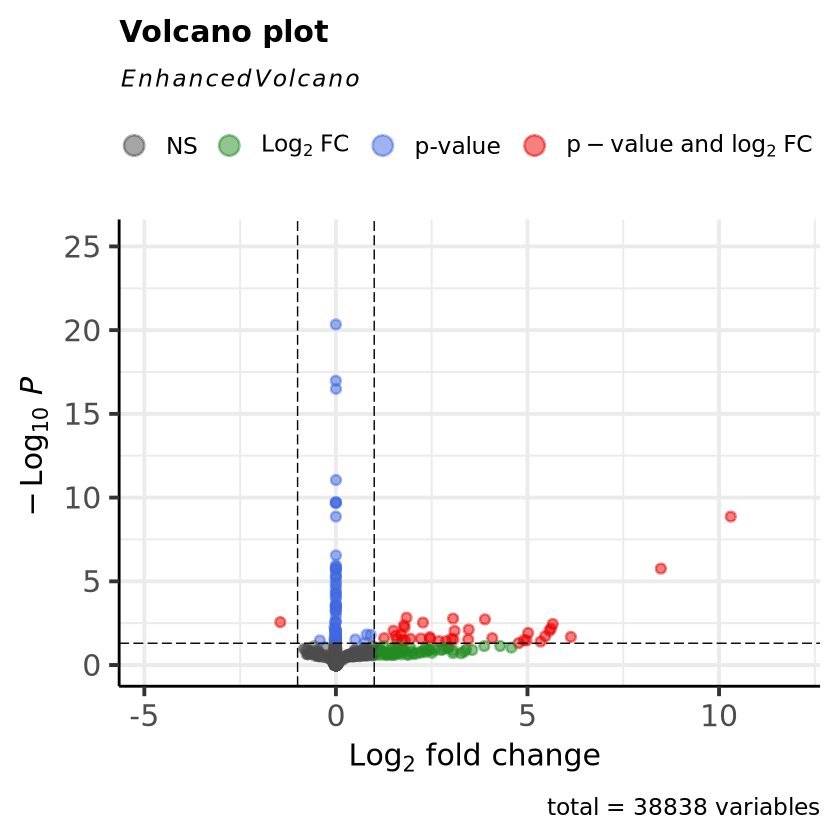

In [58]:
summary(res.wcLFC)

EnhancedVolcano(res.wcLFC,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

### phase 1 hypoxic vs. control

In [59]:
res.hc <- results(dds, name = 'Phase1_treatment_hypoxic_vs_control', alpha=0.05)
res.hc

log2 fold change (MLE): Phase1 treatment hypoxic vs control 
Wald test p-value: Phase1 treatment hypoxic vs control 
DataFrame with 38838 rows and 6 columns
              baseMean log2FoldChange     lfcSE       stat    pvalue      padj
             <numeric>      <numeric> <numeric>  <numeric> <numeric> <numeric>
LOC111116054   8.73976       1.258265  0.923619   1.362320  0.173097  0.963823
LOC111126949 670.50908      -0.144067  0.431086  -0.334194  0.738233  0.999681
LOC111110729 160.01831       0.150593  0.203649   0.739472  0.459620  0.999132
LOC111112434  13.04807      -0.166225  0.745804  -0.222881  0.823628  0.999681
LOC111120752 403.23352      -0.233491  0.357137  -0.653784  0.513251  0.999681
...                ...            ...       ...        ...       ...       ...
ND5           214540.0     0.19132774  0.221311  0.8645199  0.387302  0.997585
ND6            76772.9    -0.12868395  0.247721 -0.5194715  0.603432  0.999681
ND3            32972.9     0.08907420  0.226157  0.39

#### lfc shrinkage for visualization and ranking

In [60]:
res.hcLFC <- lfcShrink(dds, coef = 'Phase1_treatment_hypoxic_vs_control', type = 'apeglm')
res.hcLFC

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895

Warning message in nbinomGLM(x = x, Y = YNZ, size = size, weights = weightsNZ, offset = offsetNZ, :
“the line search routine failed, unable to sufficiently decrease the function value”


log2 fold change (MAP): Phase1 treatment hypoxic vs control 
Wald test p-value: Phase1 treatment hypoxic vs control 
DataFrame with 38838 rows and 5 columns
              baseMean log2FoldChange     lfcSE    pvalue      padj
             <numeric>      <numeric> <numeric> <numeric> <numeric>
LOC111116054   8.73976    0.001576916 0.0329641  0.173097  0.999656
LOC111126949 670.50908   -0.000826667 0.0328460  0.738233  0.999656
LOC111110729 160.01831    0.003853202 0.0328314  0.459620  0.999656
LOC111112434  13.04807   -0.000352766 0.0328968  0.823628  0.999656
LOC111120752 403.23352   -0.001875240 0.0328667  0.513251  0.999656
...                ...            ...       ...       ...       ...
ND5           214540.0    4.18690e-03 0.0329565  0.387302  0.999656
ND6            76772.9   -2.21720e-03 0.0327484  0.603432  0.999656
ND3            32972.9    1.86710e-03 0.0326596  0.693684  0.999656
ND1           180539.7    2.74821e-03 0.0327400  0.567377  0.999656
ND4L           10161.8   -3


out of 34981 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 48, 0.14%
LFC < 0 (down)     : 27, 0.077%
outliers [1]       : 839, 2.4%
low counts [2]     : 675, 1.9%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



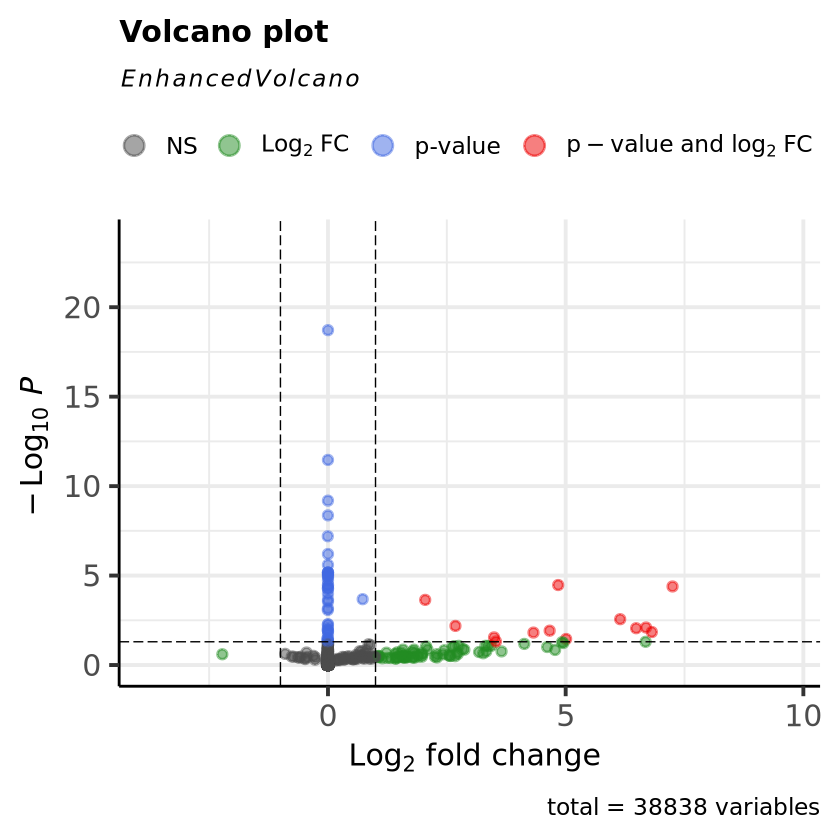

In [61]:
summary(res.hcLFC)

EnhancedVolcano(res.hcLFC,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

### phase 1 both vs. control

In [62]:
res.bc <- results(dds, name = 'Phase1_treatment_both_vs_control', alpha=0.05)
res.bc

log2 fold change (MLE): Phase1 treatment both vs control 
Wald test p-value: Phase1 treatment both vs control 
DataFrame with 38838 rows and 6 columns
              baseMean log2FoldChange     lfcSE       stat    pvalue      padj
             <numeric>      <numeric> <numeric>  <numeric> <numeric> <numeric>
LOC111116054   8.73976       0.594646  0.974559   0.610169  0.541750  0.985258
LOC111126949 670.50908       0.114894  0.451938   0.254224  0.799322  0.999195
LOC111110729 160.01831       0.111238  0.213143   0.521894  0.601744  0.989487
LOC111112434  13.04807      -0.569887  0.786097  -0.724958  0.468478  0.975957
LOC111120752 403.23352      -0.157887  0.374341  -0.421774  0.673190  0.996568
...                ...            ...       ...        ...       ...       ...
ND5           214540.0      0.1849822  0.232112  0.7969506  0.425480  0.967932
ND6            76772.9     -0.3871923  0.259813 -1.4902740  0.136152  0.815323
ND3            32972.9      0.0355470  0.237193  0.1498652 

#### lfc shrinkage for visualization and ranking

In [63]:
res.bcLFC <- lfcShrink(dds, 
                       coef = 'Phase1_treatment_both_vs_control', 
                       type = 'apeglm')
res.bcLFC

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



log2 fold change (MAP): Phase1 treatment both vs control 
Wald test p-value: Phase1 treatment both vs control 
DataFrame with 38838 rows and 5 columns
              baseMean log2FoldChange     lfcSE    pvalue      padj
             <numeric>      <numeric> <numeric> <numeric> <numeric>
LOC111116054   8.73976     0.00127501 0.0447039  0.541750  0.986377
LOC111126949 670.50908     0.00113903 0.0445266  0.799322  0.999634
LOC111110729 160.01831     0.00475725 0.0441241  0.601744  0.990498
LOC111112434  13.04807    -0.00178030 0.0447088  0.468478  0.976963
LOC111120752 403.23352    -0.00219733 0.0444908  0.673190  0.997381
...                ...            ...       ...       ...       ...
ND5           214540.0     0.00675495 0.0446378  0.425480  0.969148
ND6            76772.9    -0.01126112 0.0461724  0.136152  0.819727
ND3            32972.9     0.00125026 0.0439725  0.880871  0.999634
ND1           180539.7     0.00192347 0.0439840  0.818909  0.999634
ND4L           10161.8    -0.0005


out of 34981 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 138, 0.39%
LFC < 0 (down)     : 287, 0.82%
outliers [1]       : 839, 2.4%
low counts [2]     : 3262, 9.3%
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



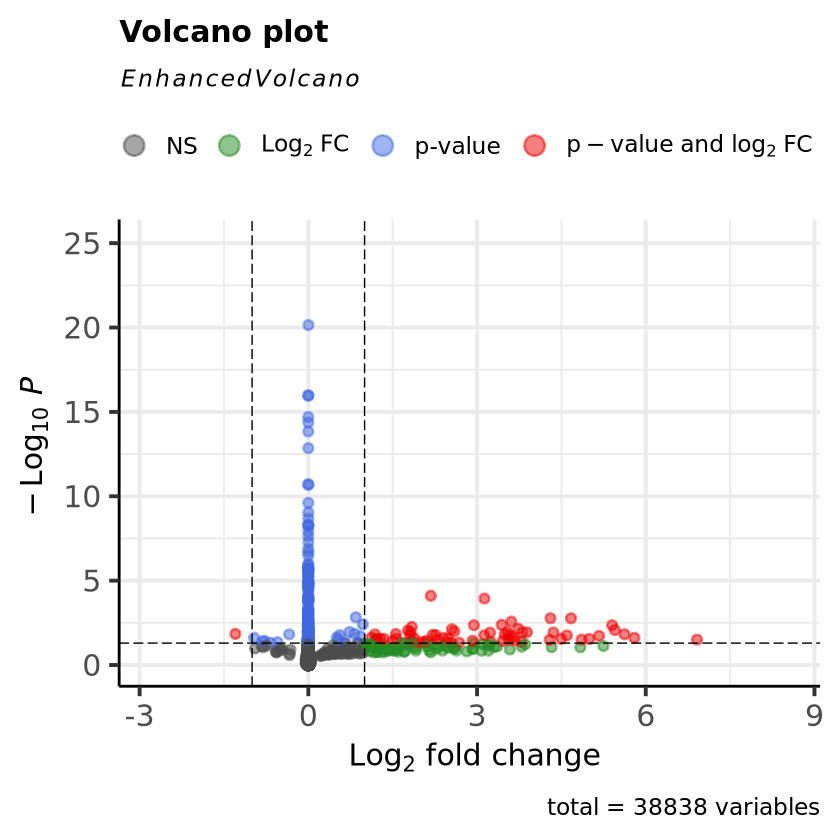

In [64]:
summary(res.bcLFC)

EnhancedVolcano(res.bcLFC,
                lab = NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff = 0.05)